In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

Using TensorFlow backend.


In [2]:
np.random.seed(0)

## Data Visualisation

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.


In [4]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)  
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [5]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

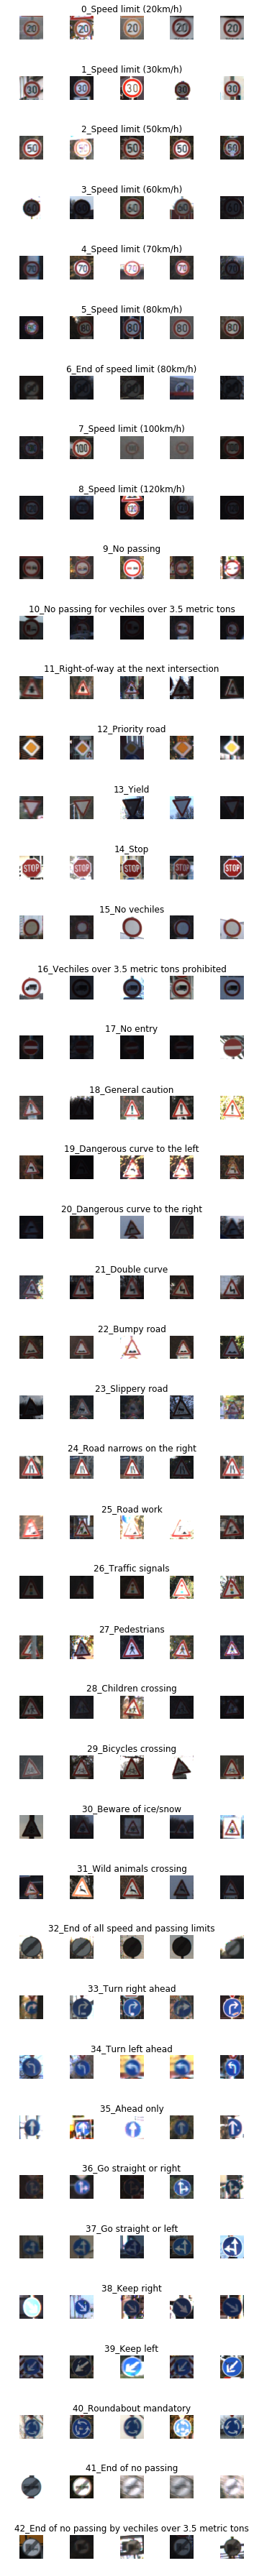

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))
            
            

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

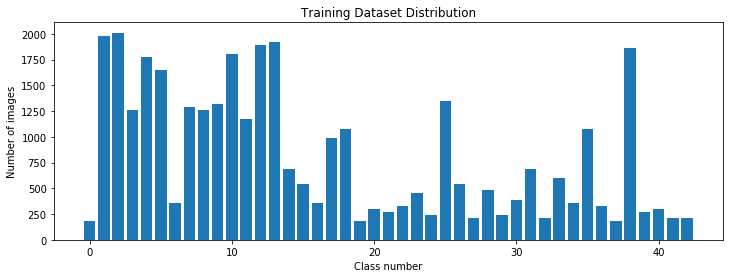

In [9]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")

## Preprocessing the training images

(32, 32, 3)
36


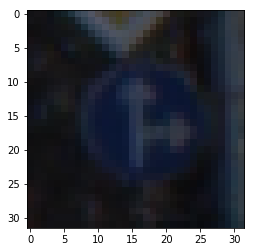

In [10]:
plt.imshow(X_train[1000])
print(X_train[1000].shape)
print(y_train[1000])

## GrayScale Conversion

In [11]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

(32, 32)


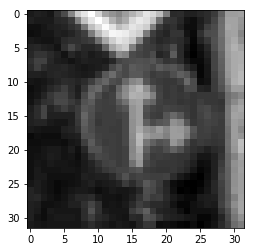

In [12]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

## Histogram Equalisation

In [13]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


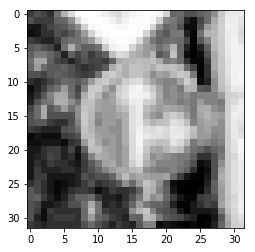

In [14]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [15]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [16]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [17]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [18]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

## Neural Network model

In [19]:
def neural_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [20]:
model = neural_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)          0         
__________

In [21]:
history = model.fit(X_train, y_train, epochs = 15, validation_data =(X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/15
34799/34799 [==============================] - 342s 10ms/step - loss: 2.4513 - acc: 0.3386 - val_loss: 0.7688 - val_acc: 0.7980
Epoch 2/15
34799/34799 [==============================] - 305s 9ms/step - loss: 0.7407 - acc: 0.7683 - val_loss: 0.3092 - val_acc: 0.9184
Epoch 3/15
34799/34799 [==============================] - 387s 11ms/step - loss: 0.4055 - acc: 0.8759 - val_loss: 0.2107 - val_acc: 0.9365
Epoch 4/15
34799/34799 [==============================] - 290s 8ms/step - loss: 0.2831 - acc: 0.9115 - val_loss: 0.1443 - val_acc: 0.9549
Epoch 5/15
34799/34799 [==============================] - 281s 8ms/step - loss: 0.2281 - acc: 0.9300 - val_loss: 0.1164 - val_acc: 0.9626
Epoch 6/15
34799/34799 [==============================] - 281s 8ms/step - loss: 0.1866 - acc: 0.9416 - val_loss: 0.0962 - val_acc: 0.9717
Epoch 7/15
34799/34799 [==============================] - 281s 8ms/step - loss: 0.1624 - acc: 0.9492 - val_loss: 0.0821 -

Text(0.5, 0, 'epoch')

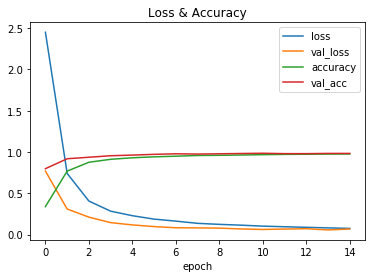

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['loss', 'val_loss', 'accuracy', 'val_acc'])
plt.title('Loss & Accuracy')
plt.xlabel('epoch')

In [23]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score', score[0])
print('Test Accuracy', score[1])

12630/12630 [==============================] - 36s 3ms/step
Test Score 0.1228519114576463
Test Accuracy 0.963816310391007


## Testing Sample Images

In [25]:
img = cv2.imread('Testing Images/sample1.jpg')
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = 'gray')

TypeError: src data type = 17 is not supported

In [ ]:
image = image/255
image = image.reshape(1, 32,32, 1)

In [ ]:
prediction = model.predict_classes(image)
print(str(prediction))